In [134]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import sys
sys.path.append("../")
from src import cleaner, model
from src.api_client import EventAPIClient

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Import data
data = pd.read_json('../data/data.json')

In [119]:
# Clean data and OHE columns
cleaned_data = cleaner.clean_with_target(data)
cleaned_data = cleaner.ohe_existence(cleaned_data, ['email_domain', 'payee_name'])

In [120]:
cleaned_data.head()

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,5,-1,840,0.0,0,0,1,3,1259613950,1,840,25.777471,-80.133433,1,0,36000,370132.0,3125756,1,0
1,0,-1,840,1.0,0,1,0,2,1280942776,3,840,32.776566,-79.930922,0,49,32400,625.0,12889894,1,1
2,8,-1,840,1.0,0,0,1,2,1272559388,3,840,33.944201,-118.080419,0,36,27000,952.0,18531568,1,1
3,6,-1,978,1.0,0,1,1,1,1283870102,3,-1,NaN,NaN,0,21,27831600,1876.0,76811468,1,0
4,11,-1,840,0.0,1,0,1,2,1288984065,3,840,42.353848,-71.044276,0,49,28800,300.0,3010601,1,1


In [150]:
client = EventAPIClient()
new_data = client.get_data()
pd.DataFrame(new_data)

,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,sequence_number
0,3660,11,US,USD,1.0,"<p><span style=""font-size: medium;"">As a value...",gmail.com,1352073604,1366678800,1.352074e+09,...,0,1352073120,1,600 N Ashley Dr,US,27.948792,-82.46156,Curtis Hixon Park,FL,2929


In [152]:
cleaner.clean_row(new_data)

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,11,-1,840,1.0,0,1,1,2,1352073120,1,840,0,93600,867.0,484,1,1


In [139]:
model.predict_new_data(new_data)

(0, 0.01)

# Set up Random Forest

In [136]:
def check_none(df):
    cols = df.columns
    for col in cols:
        print(col, (df[col] == 'None').sum())

In [121]:
# Limit columns for first round of modeling
to_keep = ['channels', 'country', 'currency', 'delivery_method', 'fb_published',
       'has_logo', 'listed', 'payout_type', 'user_created', 'user_type',
       'venue_country', 'n_previous_payouts', 'event_duration', 'fraud',
       'event_till_publish', 'user_event_lifespan', 'has_email_domain',
       'has_payee_name']
model_df = cleaned_data[to_keep]
model_df.info(), model_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   channels             14337 non-null  int64  
 1   country              14337 non-null  int64  
 2   currency             14337 non-null  int64  
 3   delivery_method      14321 non-null  float64
 4   fb_published         14337 non-null  int64  
 5   has_logo             14337 non-null  int64  
 6   listed               14337 non-null  int64  
 7   payout_type          14337 non-null  int64  
 8   user_created         14337 non-null  int64  
 9   user_type            14337 non-null  int64  
 10  venue_country        14337 non-null  int64  
 11  n_previous_payouts   14337 non-null  int64  
 12  event_duration       14337 non-null  int64  
 13  fraud                14337 non-null  int64  
 14  event_till_publish   14238 non-null  float64
 15  user_event_lifespan  14337 non-null 

(None,
 channels                0
 country                 0
 currency                0
 delivery_method        16
 fb_published            0
 has_logo                0
 listed                  0
 payout_type             0
 user_created            0
 user_type               0
 venue_country           0
 n_previous_payouts      0
 event_duration          0
 fraud                   0
 event_till_publish     99
 user_event_lifespan     0
 has_email_domain        0
 has_payee_name          0
 dtype: int64)

In [122]:
# Check to make sure no nan in dataframe
model_df = model_df.dropna()
model_df.isna().sum()

channels               0
country                0
currency               0
delivery_method        0
fb_published           0
has_logo               0
listed                 0
payout_type            0
user_created           0
user_type              0
venue_country          0
n_previous_payouts     0
event_duration         0
fraud                  0
event_till_publish     0
user_event_lifespan    0
has_email_domain       0
has_payee_name         0
dtype: int64

In [123]:
y = model_df.pop('fraud')
X = model_df.copy()

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [126]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [128]:
y_hat = model_rf.predict(X_test)
y_hat_proba = model_rf.predict_proba(X_test)
model_rf.score(X_test, y_test)

0.984822934232715

In [129]:
model_rf.feature_importances_

array([0.02453947, 0.        , 0.01286098, 0.01866599, 0.00287909,
       0.0103826 , 0.00627027, 0.10770931, 0.08856555, 0.03785132,
       0.02257335, 0.45804938, 0.04300813, 0.06950255, 0.09056127,
       0.        , 0.00658075])

In [130]:
y_hat_proba[0], model_rf.classes_

(array([1., 0.]), array([0, 1], dtype=int64))

In [131]:
model_rf.predict_proba(np.array(X_test.iloc[10]).reshape(1,-1))

array([[1., 0.]])

In [147]:
y_hat_proba

array([[1.  , 0.  ],
       [0.96, 0.04],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.89, 0.11]])

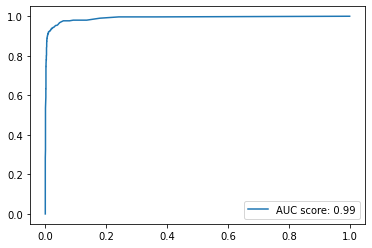

In [149]:
# ROC curve
auc = round(roc_auc_score(y_test, y_hat_proba[:,1]), 2)
fpr, tpr, thresh = roc_curve(y_test, y_hat_proba[:,1])
plt.plot(fpr, tpr, label=f'AUC score: {auc}')
plt.legend()

In [141]:
# Confusion Matrix
confusion_matrix(y_test, y_hat)

array([[3239,   16],
       [  38,  265]])

In [142]:
with open("../models/random_forest_modelv3.pkl", 'wb') as f:
    pickle.dump(model_rf, f)

In [146]:
np.array(X_test.iloc[10]).reshape(1,-1)

(1, 17)